In [1]:
import tensorflow as tf
import numpy as np

In [2]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = datagen.flow_from_directory(
    'dataset_three_classes/train',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = datagen.flow_from_directory(
    'dataset_three_classes/test',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

Found 14281 images belonging to 3 classes.
Found 6620 images belonging to 3 classes.


In [3]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [42]:
def mish_shallow():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(160, 160, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(512, activation=mish),
        tf.keras.layers.Dense(1024, activation=mish, kernel_regularizer=tf.keras.regularizers.l1_l2(0.0001)),
        #tf.keras.layers.Dense(1024, activation=mish, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.summary()

    return model

def new_mish_shallow():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(160, 160, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=mish),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.summary()

    return model

In [43]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 140:
        return 0.0001
    elif epoch < 200:
        return 0.00006
    elif epoch < 300:
        return 0.00003

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [44]:
model = new_mish_shallow()
#model = mish_shallow()
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=scheduler(0)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 160, 160, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 80, 80, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 80, 80, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 40, 40, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 40, 40, 128)      

In [46]:
with tf.device('/gpu:0'):
    history = model.fit(train_datagen, epochs=200, batch_size=32, validation_data=test_datagen, verbose=1, steps_per_epoch=16, validation_steps=16, callbacks=[scheduler_callback])

Epoch 1/200
16/16 [==============================] - 3s 163ms/step - loss: 1.2436 - accuracy: 0.5332 - val_loss: 0.9391 - val_accuracy: 0.6504 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 2s 156ms/step - loss: 1.4358 - accuracy: 0.4668 - val_loss: 0.8620 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 2s 125ms/step - loss: 1.0171 - accuracy: 0.5293 - val_loss: 0.9640 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 3s 215ms/step - loss: 1.5822 - accuracy: 0.4824 - val_loss: 0.9103 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 2s 131ms/step - loss: 1.2028 - accuracy: 0.4863 - val_loss: 0.9223 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 2s 123ms/step - loss: 1.0902 - accuracy: 0.4990 - val_loss: 1.2267 - val_accuracy: 0.0918 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 2s 126ms/st

In [ ]:
# Model Validation
eval_hist_train = model.evaluate(train_datagen)
eval_hist_test = model.evaluate(test_datagen)

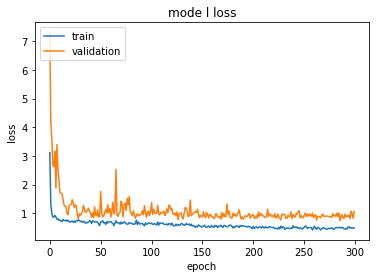

In [36]:
import matplotlib.pyplot as plt

# Save Train result
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mode l loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#fig2.savefig('history/loss16_new_augmen.jpg')

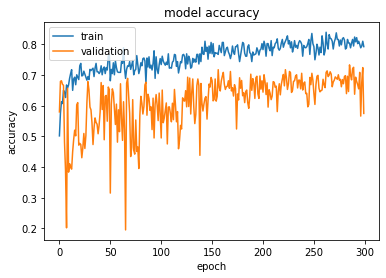

In [37]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
|